In [22]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator
from opac_mixer.mix import compute_ggrid
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

from sklearn.linear_model import LinearRegression
import m2cgen

%matplotlib widget

In [23]:
R='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files = glob.glob(os.path.join(base,f'*_R_{R}/*.h5'))
batchsize = int(2**16)

load = True
load_model = False

In [24]:
opac = ReadOpacChubb(files)
emulator = Emulator(opac, filename_data=f'data/dataset_{R}_{batchsize}.h5')

In [25]:
if load:
    X_train, X_test, y_train, y_test = emulator.load_data()
else:
    emulator.setup_sampling_grid(batchsize=batchsize)
    X_train, X_test, y_train, y_test = emulator.setup_mix(do_parallel=True)

In [26]:
def transform_x(x):
    x_trans = np.empty_like(x)
    x_trans[:,:-1] = np.log(x[:,:-1])
    x_trans[:,-1] = x[:,-1]
    return x_trans

# x_mean = transform_x(X_train).mean(axis=0)
# x_std = transform_x(X_train).std(axis=0)

# def input_scaling(x):
#     return 0.5*(transform_x(x)-x_mean[np.newaxis,:])/x_std[np.newaxis,:]

def input_scaling(x):
    return transform_x(x)

emulator.setup_scaling(inv_output_scaling = lambda x: np.exp(x), output_scaling=lambda x: np.log(x), input_scaling=input_scaling)
# emulator.setup_scaling(input_scaling=input_scaling, inv_output_scaling = lambda x: x, output_scaling=lambda x: x)

In [27]:
def log_cosh_obj(preds, dtrain):
    x = preds - dtrain.get_labels()
    grad = np.tanh(x)
    hess = 1 / np.cosh(x)**2
    return grad, hess


def gradient(predt, dtrain):
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt, dtrain):
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt, dtrain):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.

    :math:`\frac{1}{2}[log(pred + 1) - log(label + 1)]^2`

    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

def rmsle(predt, dtrain):
    ''' Root mean squared log error metric.

    :math:`\sqrt{\frac{1}{N}[log(pred + 1) - log(label + 1)]^2}`
    '''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [28]:
# model = Sequential()
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(10))

# model.compile(optimizer='Adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [29]:
emulator.setup_model(n_estimators=100, max_depth=8, tree_method='hist', filename=f'data/model_R_{R}_{batchsize}', load=load_model)

In [30]:
# emulator.model.dump_model('')

In [31]:
config = emulator.model.get_xgb_params()
print(config)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'eval_metric': 'rmse', 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


In [32]:
emulator.fit()

[0]	validation_0-rmse:13.62783	validation_1-rmse:13.52649
[1]	validation_0-rmse:11.03193	validation_1-rmse:10.94703
[2]	validation_0-rmse:8.95769	validation_1-rmse:8.88746
[3]	validation_0-rmse:7.30542	validation_1-rmse:7.24856
[4]	validation_0-rmse:5.99149	validation_1-rmse:5.94655
[5]	validation_0-rmse:4.95001	validation_1-rmse:4.91562
[6]	validation_0-rmse:4.12632	validation_1-rmse:4.10089
[7]	validation_0-rmse:3.47998	validation_1-rmse:3.46335
[8]	validation_0-rmse:2.97094	validation_1-rmse:2.96319
[9]	validation_0-rmse:2.57413	validation_1-rmse:2.57484
[10]	validation_0-rmse:2.26504	validation_1-rmse:2.27375
[11]	validation_0-rmse:2.02532	validation_1-rmse:2.04182
[12]	validation_0-rmse:1.83772	validation_1-rmse:1.86163
[13]	validation_0-rmse:1.69039	validation_1-rmse:1.72124
[14]	validation_0-rmse:1.57469	validation_1-rmse:1.61241
[15]	validation_0-rmse:1.48403	validation_1-rmse:1.52799
[16]	validation_0-rmse:1.41060	validation_1-rmse:1.46053
[17]	validation_0-rmse:1.35136	valida

In [33]:
y_predict_test = emulator.predict(emulator.X_test, shape='same')
y_predict_test_scaled = emulator.model.predict(emulator.X_test)
print('r2score on test:', r2_score(y_true=emulator.y_test, y_pred=y_predict_test))
print('mean squared error on test:', np.sqrt(mean_squared_error(y_true=emulator.y_test, y_pred=y_predict_test)))
print('mean absolute percentage error on :', mean_absolute_percentage_error(y_true=emulator.y_test, y_pred=y_predict_test))

print('r2score on scaled test:', r2_score(y_true=emulator.output_scaling(emulator.y_test), y_pred=y_predict_test_scaled))
print('mean squared error on scaled test:', np.sqrt(mean_squared_error(y_true=emulator.output_scaling(emulator.y_test), y_pred=y_predict_test_scaled)))
print('mean absolute percentage error on scaled test:', mean_absolute_percentage_error(y_true=emulator.output_scaling(emulator.y_test), y_pred=y_predict_test_scaled))

r2score on test: -11.960510302811517
mean squared error on test: 7.431703208818106
mean absolute percentage error on : 7.575728844712489
r2score on scaled test: -3.309441066070123
mean squared error on scaled test: 15.582877853164206
mean absolute percentage error on scaled test: 1.5026263319801214


In [34]:
y_predict_train = emulator.predict(emulator.X_train, shape='same')
y_predict_train_scaled = emulator.model.predict(emulator.X_train)

print('r2score on train:', r2_score(y_true=emulator.y_train, y_pred=y_predict_train))
print('mean squared error on train:', np.sqrt(mean_squared_error(y_true=emulator.y_train, y_pred=y_predict_train)))
print('mean absolute percentage error on train:', mean_absolute_percentage_error(y_true=emulator.y_train, y_pred=y_predict_train))

print('r2score on scaled train:', r2_score(y_true=emulator.output_scaling(emulator.y_train), y_pred=y_predict_train_scaled, force_finite=True))
print('mean absolute error on scaled train:', np.sqrt(mean_squared_error(y_true=emulator.output_scaling(emulator.y_train), y_pred=y_predict_train_scaled)))
print('mean absolute percentage error on scaled train:', mean_absolute_percentage_error(y_true=emulator.output_scaling(emulator.y_train), y_pred=y_predict_train_scaled))

r2score on train: 0.944223506382059
mean squared error on train: 3.306977389039393
mean absolute percentage error on train: 0.9152173430762287
r2score on scaled train: -3.313336446348498
mean absolute error on scaled train: 15.707740875873572
mean absolute percentage error on scaled train: 1.4624023268361888


In [35]:
y_predict = {'test': emulator.reshape(y_predict_test), 'train': emulator.reshape(y_predict_train)}
y_true = {'test':emulator.reshape(emulator.y_test), 'train': emulator.reshape(emulator.y_train)}

interactive(children=(FloatSlider(value=0.0, description='index_frac', max=0.99, step=0.05), Dropdown(descript…

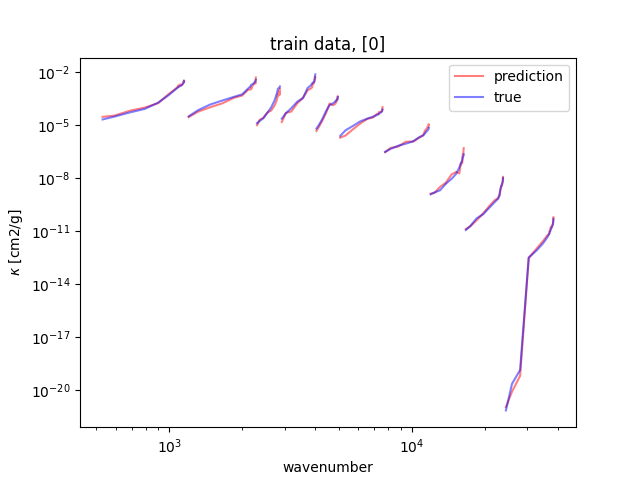

In [36]:
fig_tes, ax_tes = plt.subplots(1,1)
def plot_single_prediction(index_frac, mode):
    ax_tes.cla()
    index = np.array([int(index_frac*len(y_predict[mode]))])
    for fi in range(y_predict[mode].shape[1]):
        x = opac.bin_edges[fi]+opac.weights.cumsum()*(opac.bin_edges[fi+1]-opac.bin_edges[fi])
        lp, = ax_tes.loglog(x,y_predict[mode][index][0,fi,:], color ='red', alpha=0.5)
        lt, = ax_tes.loglog(x,y_true[mode][index][0,fi,:], color = 'blue', alpha=0.5)
        
    # ax_tes.set_yscale('linear')
    ax_tes.set_ylabel(r'$\kappa$ [cm2/g]')
    ax_tes.set_xlabel(r'wavenumber')
    ax_tes.set_title(f'{mode} data, {index}')
    ax_tes.legend([lp,lt],['prediction','true'])

interact(plot_single_prediction, index_frac=FloatSlider(min=0., max=.99, step=0.05, value=0.), mode=Dropdown(options=['train','test']));

interactive(children=(IntSlider(value=0, description='freqi', max=9), IntSlider(value=0, description='gi', max…

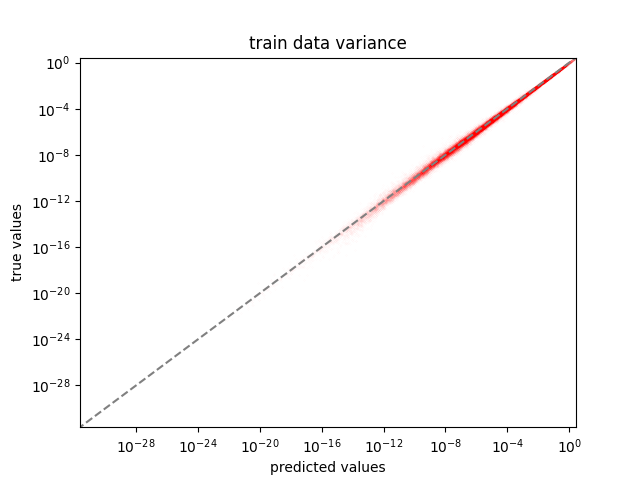

In [37]:
fig_t, ax_t = plt.subplots(1,1) 
lt, = ax_t.plot(y_predict['test'][:,0,0], y_true['test'][:,0,0], 'ro', ms=0.01, linestyle="None")
ax_t.set_xscale('log')
ax_t.set_yscale('log')
dt, = ax_t.plot([y_predict['test'][:,0,0].min(), y_predict['test'][:,0,0].max()], [y_predict['test'][:,0,0].min(), y_predict['test'][:,0,0].max()], color = 'gray', ls = '--')
ax_t.set_ylabel('true values')
ax_t.set_xlabel('predicted values')
    

def update_prediction_test(freqi, gi, mode):
    lt.set_ydata(y_true[mode][:,freqi,gi])
    lt.set_xdata(y_predict[mode][:,freqi,gi])    
    dt.set_ydata([y_predict[mode][:,freqi,gi].min(), y_predict[mode][:,freqi,gi].max()])
    dt.set_xdata([y_predict[mode][:,freqi,gi].min(), y_predict[mode][:,freqi,gi].max()])
    ax_t.set_xlim([y_true[mode][:,freqi,gi].min(),y_true[mode][:,freqi,gi].max()])
    ax_t.set_ylim([y_true[mode][:,freqi,gi].min(),y_true[mode][:,freqi,gi].max()])        
    ax_t.set_title(f'{mode} data variance')
    fig_t.canvas.draw_idle()


interact(update_prediction_test, freqi=IntSlider(min=0, max=opac.lf[0]-1, step=1, value=0),gi=IntSlider(min=0, max=opac.lg[0]-1, step=1, value=0), mode=Dropdown(options=['train','test']));

In [38]:
indent = 4
code = m2cgen.export_to_fortran(emulator.model, module_name="exorad_ml_mod", function_name="exorad_ml_mod_pred", indent=indent)

In [39]:
lines = code.split('\n')
mod_pre = "\n".join(lines[:2])
mod_cont = "\n".join(lines[2:])

In [40]:
const_c = 2.99792458e10  # speed of light in cgs
mod_constants_tpl = """
    real*8, parameter, dimension({len_freq}) :: mod_freqedges = (/ {freq} /)
    real*8, parameter, dimension({len_gweights}) :: mod_gweights = (/ {gweights} /)
    CHARACTER(len=10), parameter, dimension({len_spec}) :: mod_species = (/ {spec} /)    
    INTEGER, parameter :: mod_len_gweights = {len_gweights}
    INTEGER, parameter :: mod_len_freqedges = {len_freq} 
    INTEGER, parameter :: mod_len_species = {len_spec}
"""
freqedges = emulator.opac.bin_edges * const_c
freqedges_str = ",".join([str(freqi) for freqi in freqedges])

gweights = compute_ggrid(emulator.opac.weights, emulator.opac.lg[0])
gweights_str = ",".join([str(gi) for gi in gweights])

species_str = ', '.join(['"{:10s}"'.format(sp) for sp in emulator.opac.spec])

mod_constants = mod_constants_tpl.format(freq=freqedges_str, len_freq=len(freqedges), gweights=gweights_str, len_gweights=len(gweights), len_spec=len(emulator.opac.spec), spec=species_str)

In [41]:
export_dirs = ["exorad_ml_mod.F90", "/Users/schneider/codes/exo/exorad/verification/ML/code/exorad_ml_mod.F90"]
for filename in export_dirs:
    with open(filename, 'w') as f:
        f.write(mod_pre)
        f.write(mod_constants)
        f.write(mod_cont)

In [42]:
species_str

'"NH3       ", "CO        ", "TiO       ", "H2O       ", "PH3       ", "VO        ", "HCN       ", "Na        ", "FeH       ", "SiO       ", "K         ", "CO2       ", "H2S       ", "CH4       "'